In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Machine Learning
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor #or any model of your choice
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.metrics import make_scorer, mean_squared_error
#To get the root mean squared error
'''
rmse=mean_squared_error(y_true,y_pred,squared=False)
'''


# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

Loading Dataset

In [ ]:
try:
    train_df= pd.read_csv("archive/train.csv")
    test_df = pd.read_csv("archive/test.csv")
    print("Data loaded successfully!")
except FileNotFoundError:
    print("Error: The file 'car_prices.csv' was not found. Please check the file path.")

Data loaded successfully!


Dataset preview(first 5 row)

In [ ]:
print(train_df.head(5))

   id          brand              model  model_year  milage      fuel_type  \
0   0           MINI      Cooper S Base        2007  213000       Gasoline   
1   1        Lincoln              LS V8        2002  143250       Gasoline   
2   2      Chevrolet  Silverado 2500 LT        2002  136731  E85 Flex Fuel   
3   3        Genesis   G90 5.0 Ultimate        2017   19500       Gasoline   
4   4  Mercedes-Benz        Metris Base        2021    7388       Gasoline   

                                              engine  \
0       172.0HP 1.6L 4 Cylinder Engine Gasoline Fuel   
1       252.0HP 3.9L 8 Cylinder Engine Gasoline Fuel   
2  320.0HP 5.3L 8 Cylinder Engine Flex Fuel Capab...   
3       420.0HP 5.0L 8 Cylinder Engine Gasoline Fuel   
4       208.0HP 2.0L 4 Cylinder Engine Gasoline Fuel   

                     transmission ext_col int_col  \
0                             A/T  Yellow    Gray   
1                             A/T  Silver   Beige   
2                             A/T  

Feature Engineering

In [ ]:
def feature_engineering(df):
    # 1. Car Age
    if 'model_year' in df.columns:
        current_year = 2025
        df['car_age'] = current_year - df['model_year']

    # 2. Mileage per Year
    if 'milage' in df.columns and 'car_age' in df.columns:
        df['milage_per_year'] = df['milage'] / df['car_age'].replace(0, 1)

    # 3. Extracting features from engine column
    if 'engine' in df.columns:
        # Extracting horsepower
        df['engine_hp'] = df['engine'].str.extract(r'(\d+\.?\d*)HP').astype(float)
        # Extracting engine size in liters
        df['engine_L'] = df['engine'].str.extract(r'(\d+\.?\d*)L').astype(float)
        # Extracting number of cylinders
        df['engine_cyl'] = df['engine'].str.extract(r'(\d+) Cylinder').astype(float)

    # 4. Is car new (age 0 or 1)
    if 'car_age' in df.columns:
        df['is_new'] = (df['car_age'] <= 1).astype(int)

    # 5. Log transformation of milage (to reduce skewness)
    if 'milage' in df.columns:
        df['log_milage'] = np.log1p(df['milage'])

    # 6. Interaction feature: horsepower per liter
    if 'engine_hp' in df.columns and 'engine_L' in df.columns:
        df['hp_per_L'] = df['engine_hp'] / df['engine_L'].replace(0, np.nan)

    # 7. Combine brand and model
    if 'brand' in df.columns and 'model' in df.columns:
        df['brand_model'] = df['brand'].astype(str) + '_' + df['model'].astype(str)
        return df 

Applying feature Engineering to both train and test datasets

In [ ]:
train_df = feature_engineering(train_df)
test_df = feature_engineering(test_df)

Dropping unnecessary columns after feature engineering

In [ ]:
# Droping unnecessary columns
columns_to_drop = ['id', 'model_year', 'milage', 'clean_title', 'engine','clean_title']
train_df = train_df.drop(columns=[col for col in columns_to_drop if col in train_df.columns])
test_df = test_df.drop(columns=[col for col in columns_to_drop if col in test_df.columns])

Exploratory Data Analysis

In [ ]:
def plots(columns,ncols_for_subplot, df):
    ncols = ncols_for_subplot
    nrows = -(-len(columns) // ncols)  # ceiling division

    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15, 5 * nrows))
    axes = axes.flatten()

    for i, col in enumerate(columns):
        sns.scatterplot(x=col, y='price', data=df, ax=axes[i])
        axes[i].set_title(f'Price vs. {col}')
        axes[i].set_xlabel(col)
        axes[i].set_ylabel('Price')

    # hide unused subplots if any
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()

In [ ]:
categorical_cols = train_df.select_dtypes(include='object').columns
numerical_cols = train_df.select_dtypes(exclude='object').columns
def exploratory_data_analysis(df):
    '''This function performs some preliminary EDA.  
       
    '''
    print("First 5 rows of the dataset:")
    print(df.head())
    
    # Get information about the dataset (data types, non-null values)
    print("\nDataset information:")
    df.info()
    
    # Get descriptive statistics for numerical columns
    print("\nDescriptive statistics for numerical columns:")
    print(df.describe())
    #Get descriptive statistics for categorical columns
    print("\nDescriptive statistics for categorical columns:")
    print(df.describe(include='object'))
    #Checking for missing values
    print("\nMissing values per column:")
    print(df.isnull().sum())
    # Visualize the distribution of the target variable (price)
    plt.figure(figsize=(10, 6))
    sns.histplot(df['price'], kde=True, bins=50)
    plt.title('Distribution of Car Prices')
    plt.xlabel('Price')
    plt.ylabel('Frequency')
    plt.show()
    
    
    # Visualizing the relationship between all numerical features and price
    
    print('Plotting numerical variables vs price')
    numerical_plot=plots(numerical_cols,2,df)
   

First 5 rows of the dataset:
           brand              model      fuel_type  \
0           MINI      Cooper S Base       Gasoline   
1        Lincoln              LS V8       Gasoline   
2      Chevrolet  Silverado 2500 LT  E85 Flex Fuel   
3        Genesis   G90 5.0 Ultimate       Gasoline   
4  Mercedes-Benz        Metris Base       Gasoline   

                     transmission ext_col int_col  \
0                             A/T  Yellow    Gray   
1                             A/T  Silver   Beige   
2                             A/T    Blue    Gray   
3  Transmission w/Dual Shift Mode   Black   Black   
4                     7-Speed A/T   Black   Beige   

                                 accident  price  car_age  milage_per_year  \
0                           None reported   4200       18     11833.333333   
1  At least 1 accident or damage reported   4999       23      6228.260870   
2                           None reported  13900       23      5944.826087   
3              

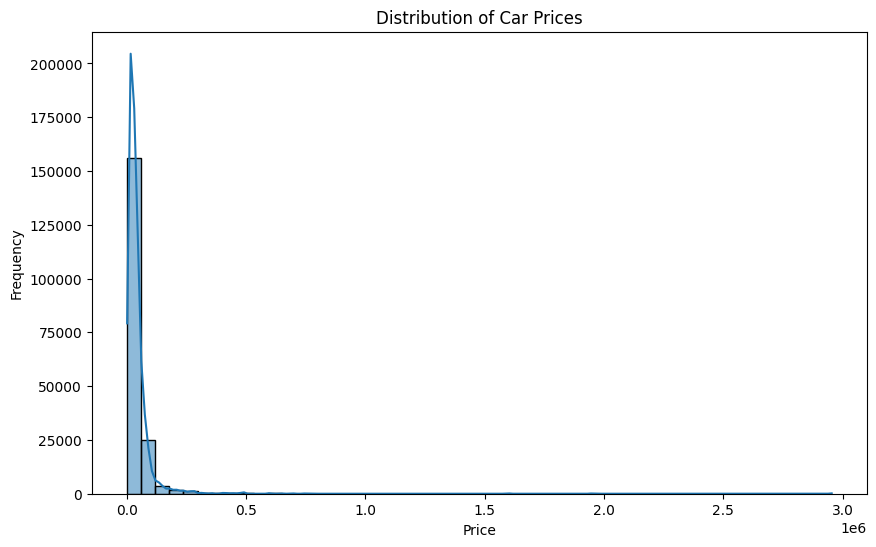

Plotting numerical variables vs price


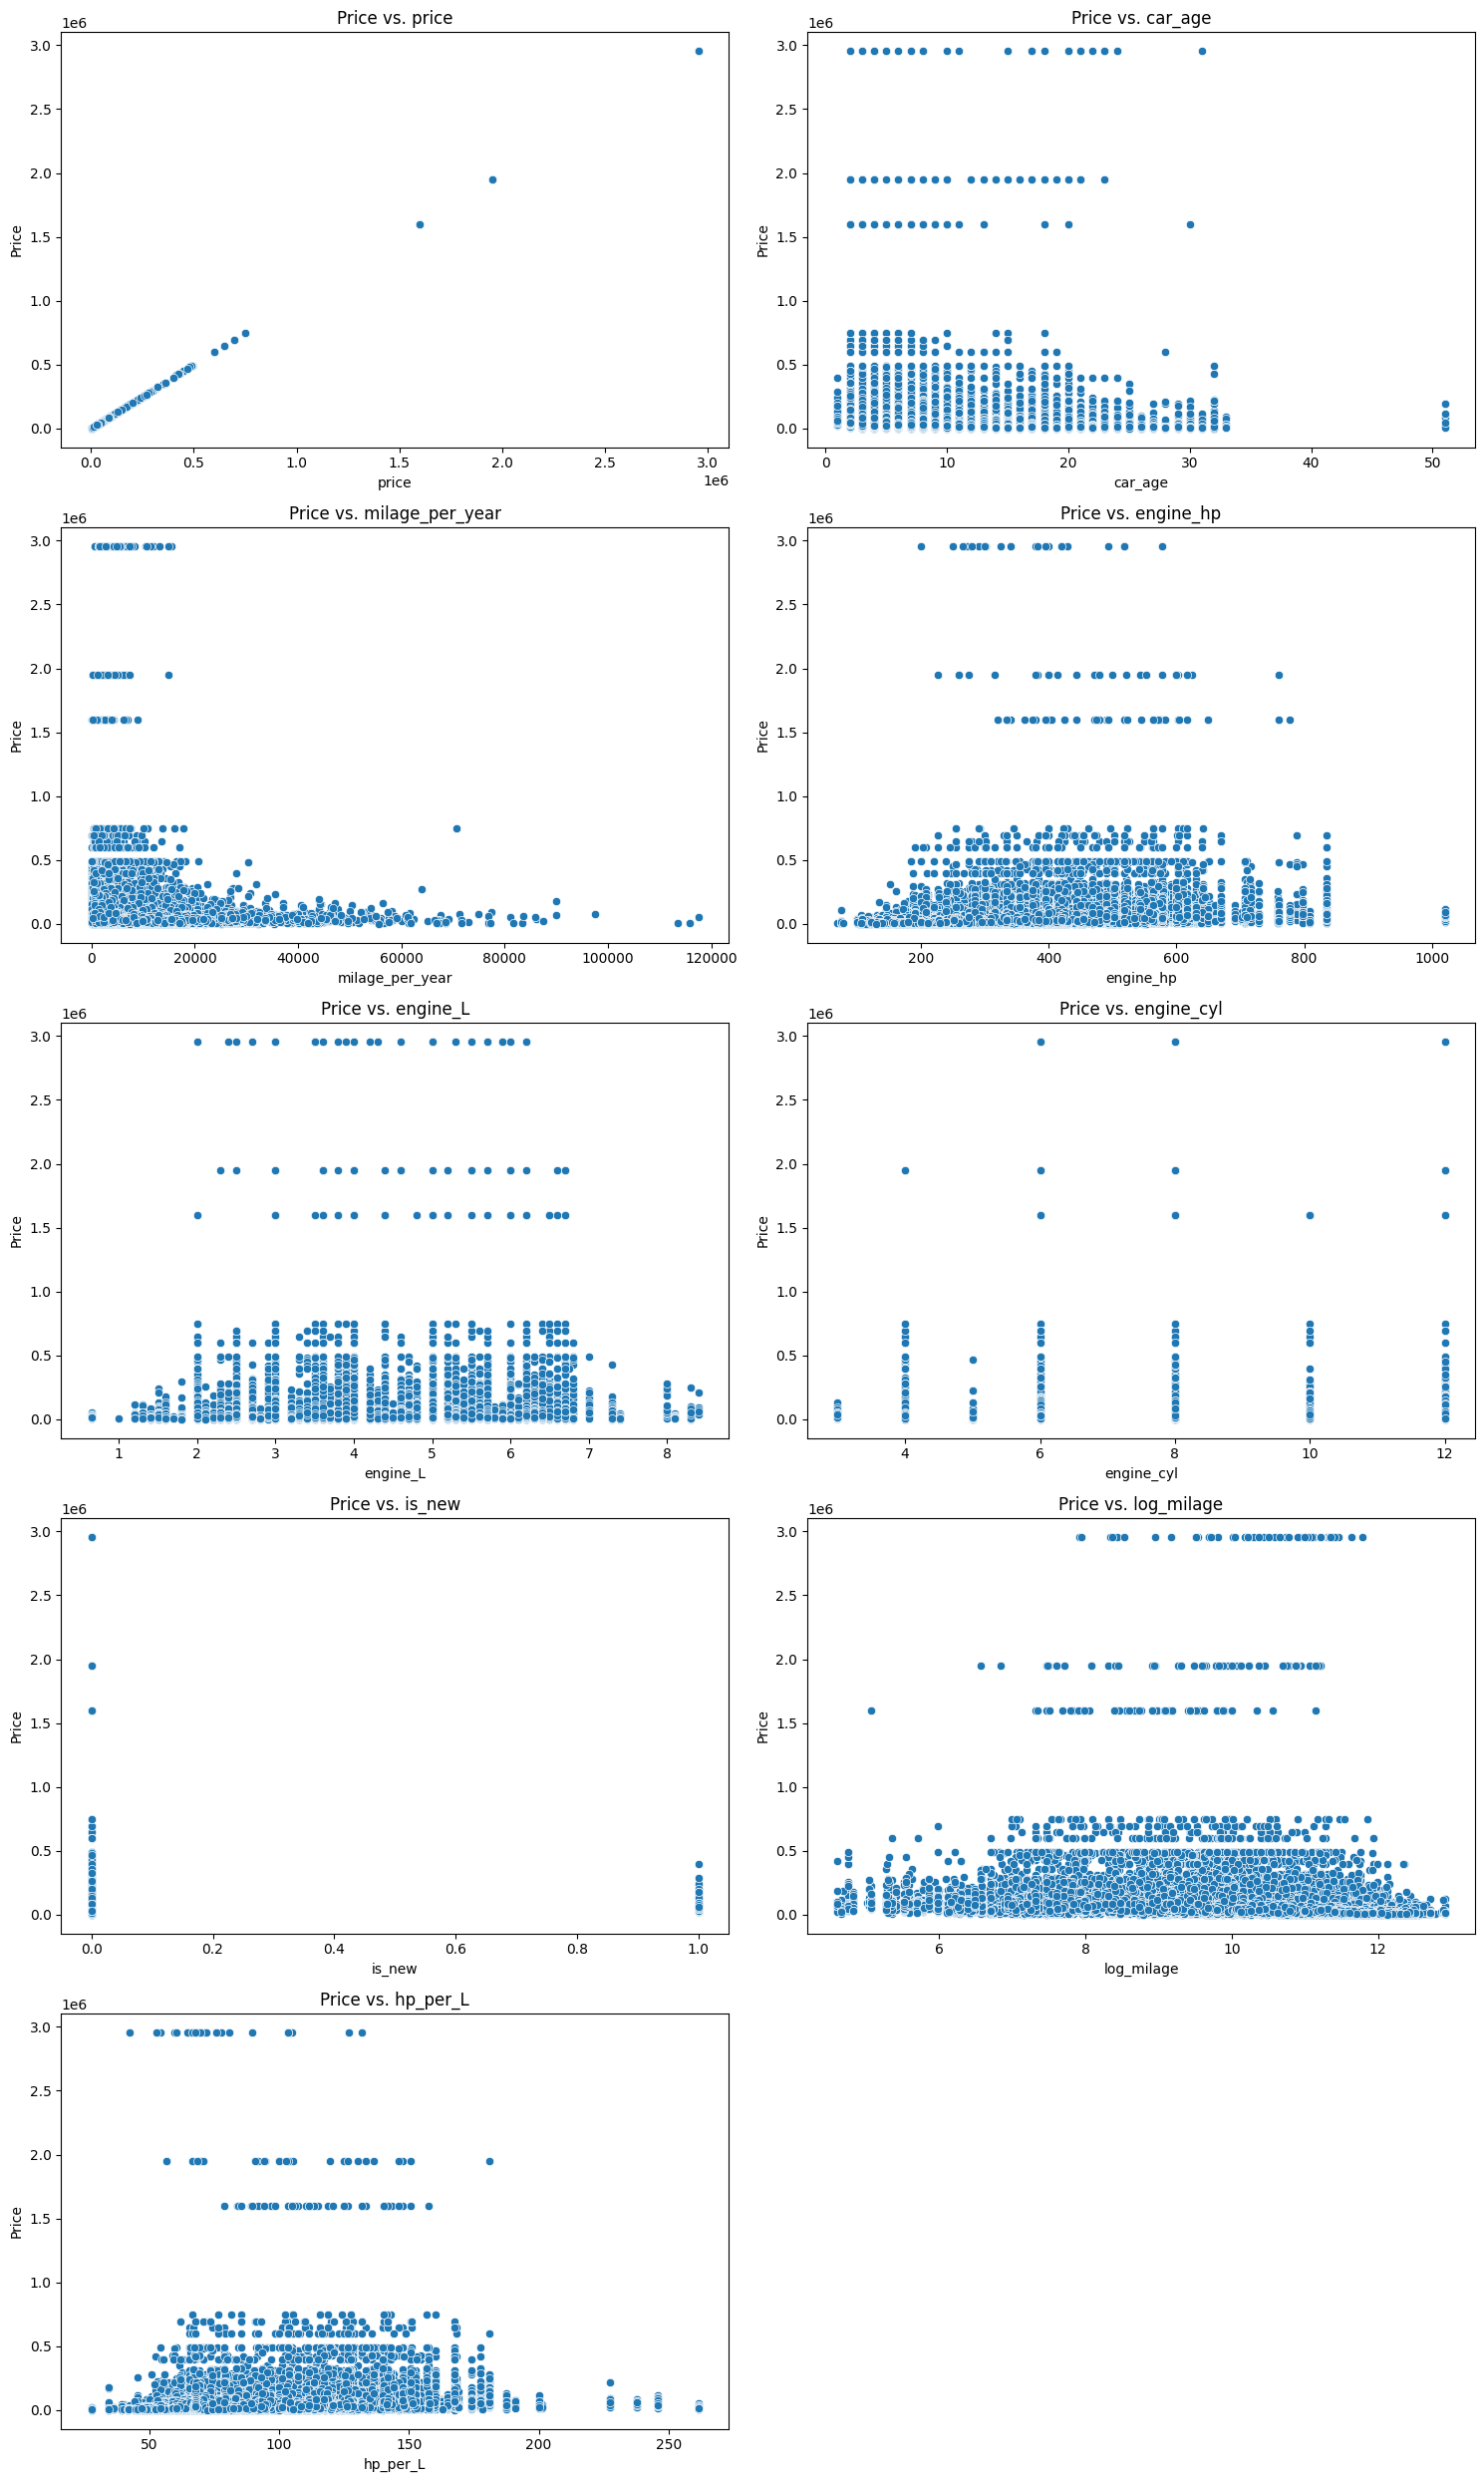

In [73]:
exploratory_data_analysis(train_df)

In [74]:
def filling_missing_values_in_numerical_columns(df):
    # Automatically detect numerical columns with missing values that exist in df
    numerical_cols_with_missing = [col for col in df.select_dtypes(include=['number']).columns if col in df.columns and df[col].isnull().any()]
    
    # Fill missing values using the median of each column
    for col in numerical_cols_with_missing:
        median_value = df[col].median()
        df[col].fillna(median_value, inplace=True)
    
    print("DataFrame after filling numerical missing values:")
    print(df.info())
    return df


In [75]:
def filling_missing_values_in_categorical_columns(df):
    # Automatically detect categorical columns with missing values that exist in df
    categorical_cols_with_missing = [col for col in df.select_dtypes(include=['object']).columns if col in df.columns and df[col].isnull().any()]

    for col in categorical_cols_with_missing:
        mode_value = df[col].mode()[0] if not df[col].mode().empty else 'missing'
        df[col].fillna(mode_value, inplace=True)
    
    print("DataFrame after filling categorical missing values:")
    print(df.info())
    return df

In [76]:
def encode_categorical_columns(df):
    le = LabelEncoder()
    # Automatically detect categorical columns in the current DataFrame
    categorical_cols = df.select_dtypes(include='object').columns
    print('Encoding variables...')
    for col in categorical_cols:
        try:
            if df[col].isnull().any():
                df[col].fillna('missing', inplace=True)
            df[col] = le.fit_transform(df[col])
            print(f"Successfully applied Label Encoding to: {col}")
        except Exception as e:
            print(f"Could not apply Label Encoding to {col}. Error: {e}")
    return df

Cleaning my data

In [77]:
def preprocessing(df):
    '''
    This function cleans your data for you. Feel free to tweak it to your tastes
    It comprises filling missing data, encoding categorical variables etc
    Perhaps feature engineering as well. Have fun!
    Argument:
        data (pd.DataFrame): The input DataFrame.
    
    Returns:
        pd.DataFrame: The preprocessed DataFrame.
    '''
    print("Step 1: Filling missing values in numerical columns")
    df = filling_missing_values_in_numerical_columns(df)
    print("Step 2: Filling missing values in categorical columns")
    df = filling_missing_values_in_categorical_columns(df)
    print("Step 3: Encoding categorical columns")
    df = encode_categorical_columns(df)
    print("Preprocessing complete!")
    return df


In [78]:
df=preprocessing(train_df)

Step 1: Filling missing values in numerical columns
DataFrame after filling numerical missing values:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 188533 entries, 0 to 188532
Data columns (total 17 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   brand            188533 non-null  object 
 1   model            188533 non-null  object 
 2   fuel_type        183450 non-null  object 
 3   transmission     188533 non-null  object 
 4   ext_col          188533 non-null  object 
 5   int_col          188533 non-null  object 
 6   accident         186081 non-null  object 
 7   price            188533 non-null  int64  
 8   car_age          188533 non-null  int64  
 9   milage_per_year  188533 non-null  float64
 10  engine_hp        188533 non-null  float64
 11  engine_L         188533 non-null  float64
 12  engine_cyl       188533 non-null  float64
 13  is_new           188533 non-null  int64  
 14  log_milage       188533 non-nu

C:\Users\HP\AppData\Local\Temp\ipykernel_7888\908014217.py:8: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna(median_value, inplace=True)
C:\Users\HP\AppData\Local\Temp\ipykernel_7888\908014217.py:8: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing

DataFrame after filling categorical missing values:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 188533 entries, 0 to 188532
Data columns (total 17 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   brand            188533 non-null  object 
 1   model            188533 non-null  object 
 2   fuel_type        188533 non-null  object 
 3   transmission     188533 non-null  object 
 4   ext_col          188533 non-null  object 
 5   int_col          188533 non-null  object 
 6   accident         188533 non-null  object 
 7   price            188533 non-null  int64  
 8   car_age          188533 non-null  int64  
 9   milage_per_year  188533 non-null  float64
 10  engine_hp        188533 non-null  float64
 11  engine_L         188533 non-null  float64
 12  engine_cyl       188533 non-null  float64
 13  is_new           188533 non-null  int64  
 14  log_milage       188533 non-null  float64
 15  hp_per_L         188533 non-null 

Spilting data into feature and target for traning

In [79]:
X = df.drop('price', axis=1) # Replacing 'price' with my target column name
y = df['price']

# Split the data into training and testing sets (80% train, 20% test)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"\nTraining set size: {len(X_train)}")
print(f"Testing set size: {len(X_val)}")


Training set size: 150826
Testing set size: 37707


In [80]:
print(X_train.head())

        brand  model  fuel_type  transmission  ext_col  int_col  accident  \
184031     36    764          1            49      128       14         0   
173831     39    732          2            38      263       71         0   
183819     14    670          2             2      128       71         0   
85525      19    583          2            20       29       14         1   
41872      11    457          2            16      234       14         1   

        car_age  milage_per_year  engine_hp  engine_L  engine_cyl  is_new  \
184031        8      7709.375000      208.0       2.0         4.0       0   
173831       22      8409.090909      239.0       4.0         6.0       0   
183819        5     18400.000000      325.0       2.7         6.0       0   
85525         2      2741.500000      276.0       2.0         4.0       0   
41872         2      2500.000000      717.0       6.2         8.0       0   

        log_milage    hp_per_L  brand_model  
184031   11.029650  104.0000

Training my model

In [81]:
def train_with_cv(estimator, param_grid, X, y, cv_splits=5, scoring=None):
    """
    Perform K-Fold Cross Validation with hyperparameter tuning.
    """
    # default scoring = RMSE for regression
    if scoring is None:
        scoring = make_scorer(mean_squared_error, squared=False)

    kfold = KFold(n_splits=cv_splits, shuffle=True, random_state=42)

    grid_search = GridSearchCV(
        estimator=estimator,
        param_grid=param_grid,
        cv=kfold,
        scoring=scoring,
        n_jobs=-1,
        verbose=1
    )

    grid_search.fit(X, y)

    return grid_search.best_estimator_, grid_search.best_params_, grid_search.cv_results_

In [ ]:
# Import LightGBM
import lightgbm as lgb
lgb_model = lgb.LGBMRegressor(random_state=42)

# Defining the model and parameter grid
lgb_param_grid = {
    'n_estimators': [100],
    'max_depth': [5, 10],
    'learning_rate': [0.05],
    'num_leaves': [31]
}

# Hyperparameter tuning with cross-validation
best_lgb_model, best_lgb_params, lgb_cv_results = train_with_cv(
    lgb_model, lgb_param_grid, X_train, y_train
)
print("Best LightGBM Params:", best_lgb_params)

# Validation prediction and RMSE for LightGBM
y_val_pred_lgb = best_lgb_model.predict(X_val)
lgb_val_rmse = np.sqrt(mean_squared_error(y_val, y_val_pred_lgb))
print("LightGBM Validation RMSE:", lgb_val_rmse)

Fitting 5 folds for each of 2 candidates, totalling 10 fits


In [ ]:
y_val_pred = best_lgb_model.predict(X_val)
val_rmse = np.sqrt(mean_squared_error(y_val, y_val_pred))
print("Validation RMSE:", val_rmse)


Validation RMSE: 67972.7351170127


In [ ]:
# Use the best LightGBM model for final training and prediction
import lightgbm as lgb

final_model = lgb.LGBMRegressor(**best_lgb_params, random_state=42)
final_model.fit(
    np.vstack([X_train, X_val]),
    np.hstack([y_train, y_val])
)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.019202 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2050
[LightGBM] [Info] Number of data points in the train set: 188533, number of used features: 16
[LightGBM] [Info] Start training from score 43878.016178
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best 

,boosting_type,'gbdt'
,num_leaves,31
,max_depth,5
,learning_rate,0.05
,n_estimators,100
,subsample_for_bin,200000
,objective,None
,class_weight,None
,min_split_gain,0.0
,min_child_weight,0.001
,min_child_samples,20


In [ ]:
test=pd.read_csv("archive/test.csv")
test.head()

,id,brand,model,model_year,milage,fuel_type,engine,transmission,ext_col,int_col,accident,clean_title
0,188533,Land,Rover LR2 Base,2015,98000,Gasoline,240.0HP 2.0L 4 Cylinder Engine Gasoline Fuel,6-Speed A/T,White,Beige,None reported,Yes
1,188534,Land,Rover Defender SE,2020,9142,Hybrid,395.0HP 3.0L Straight 6 Cylinder Engine Gasoli...,8-Speed A/T,Silver,Black,None reported,Yes
2,188535,Ford,Expedition Limited,2022,28121,Gasoline,3.5L V6 24V PDI DOHC Twin Turbo,10-Speed Automatic,White,Ebony,None reported,NaN
3,188536,Audi,A6 2.0T Sport,2016,61258,Gasoline,2.0 Liter TFSI,Automatic,Silician Yellow,Black,None reported,NaN
4,188537,Audi,A6 2.0T Premium Plus,2018,59000,Gasoline,252.0HP 2.0L 4 Cylinder Engine Gasoline Fuel,A/T,Gray,Black,None reported,Yes


In [ ]:
test_df = pd.read_csv("archive/test.csv")
test_df = feature_engineering(test_df)
columns_to_drop = ['id', 'model_year', 'milage', 'clean_title', 'engine','clean_title']
test_df = test_df.drop(columns=[col for col in columns_to_drop if col in test_df.columns])
X_test = preprocessing(test_df)
X_test.head()

Step 1: Filling missing values in numerical columns
DataFrame after filling numerical missing values:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 125690 entries, 0 to 125689
Data columns (total 16 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   brand            125690 non-null  object 
 1   model            125690 non-null  object 
 2   fuel_type        122307 non-null  object 
 3   transmission     125690 non-null  object 
 4   ext_col          125690 non-null  object 
 5   int_col          125690 non-null  object 
 6   accident         124058 non-null  object 
 7   car_age          125690 non-null  int64  
 8   milage_per_year  125690 non-null  float64
 9   engine_hp        125690 non-null  float64
 10  engine_L         125690 non-null  float64
 11  engine_cyl       125690 non-null  float64
 12  is_new           125690 non-null  int64  
 13  log_milage       125690 non-null  float64
 14  hp_per_L         125690 non-nu

C:\Users\HP\AppData\Local\Temp\ipykernel_7888\908014217.py:8: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna(median_value, inplace=True)
C:\Users\HP\AppData\Local\Temp\ipykernel_7888\908014217.py:8: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing

DataFrame after filling categorical missing values:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 125690 entries, 0 to 125689
Data columns (total 16 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   brand            125690 non-null  object 
 1   model            125690 non-null  object 
 2   fuel_type        125690 non-null  object 
 3   transmission     125690 non-null  object 
 4   ext_col          125690 non-null  object 
 5   int_col          125690 non-null  object 
 6   accident         125690 non-null  object 
 7   car_age          125690 non-null  int64  
 8   milage_per_year  125690 non-null  float64
 9   engine_hp        125690 non-null  float64
 10  engine_L         125690 non-null  float64
 11  engine_cyl       125690 non-null  float64
 12  is_new           125690 non-null  int64  
 13  log_milage       125690 non-null  float64
 14  hp_per_L         125690 non-null  float64
 15  brand_model      125690 non-null 

,brand,model,fuel_type,transmission,ext_col,int_col,accident,car_age,milage_per_year,engine_hp,engine_L,engine_cyl,is_new,log_milage,hp_per_L,brand_model
0,26,1388,2,16,302,10,1,10,9800.000000,240.0,2.0,4.0,0,11.492733,120.000000,1753
1,26,1375,3,31,261,14,1,5,1828.400000,395.0,3.0,6.0,0,9.120744,131.666667,1740
2,14,636,2,3,302,57,1,3,9373.666667,328.0,3.5,6.0,0,10.244307,87.428571,1103
3,3,182,2,39,259,14,1,9,6806.444444,328.0,3.5,6.0,0,11.022866,87.428571,108
4,3,181,2,38,127,14,1,7,8428.571429,252.0,2.0,4.0,0,10.985310,126.000000,107


In [ ]:
y_test_pred = final_model.predict(X_test)
y_test_pred[0:5]

array([ 24046.54257843, 101080.79126291,  52027.36356971,  28551.93906675,
        29758.55793125])

Submission

In [ ]:
# Loading the original test file to get the 'id' column and submission
test_ids = pd.read_csv("archive/test.csv")['id']
submission = pd.DataFrame({"id": test_ids, "Price": y_test_pred})
submission["Price"] = submission["Price"].round(3)
submission.to_csv("Submission.csv", index=False)